# Modelling SEI growth on particle cracks

This notebook provides a short demonsration of how the SEI and particle mechanics submodels can be combined to simulate SEi growth on particle cracks.

In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import matplotlib.pyplot as plt
import numpy as np

You should consider upgrading via the '/home/sokane/PyBaMM-GEM/env/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Define two models. In model1, the only degradation mechanism is solvent-diffusion limited SEI growth. model2 includes the same SEI growth mechanism but also includes particle cracking and SEI growth on the cracks. The SEI model is run twice: once on the initial surface and once on the cracks. The equations for SEI on cracks are reported by O'Kane et al. [8]

In [2]:
model1 = pybamm.lithium_ion.DFN({"SEI": "solvent-diffusion limited"})
model2 = pybamm.lithium_ion.DFN({
    "particle mechanics": "swelling and cracking",
    "SEI": "solvent-diffusion limited",
    "SEI on cracks": "true",
})

The crack propagation model is unstable around t=0, so it helps to use a mesh that puts more points at the surface.

In [3]:
param = pybamm.ParameterValues("OKane2022")

# set mesh
submesh_types = model1.default_submesh_types
particle_mesh = pybamm.MeshGenerator(pybamm.Exponential1DSubMesh, submesh_params={"side": "right", "stretch": 2.3})
submesh_types["negative particle"] = particle_mesh
submesh_types["positive particle"] = particle_mesh

Solve the models with and without cracking for a 1C discharge.

In [4]:
exp = pybamm.Experiment(["Discharge at 1C until 2.5 V"])
sim1 = pybamm.Simulation(model1, parameter_values=param, experiment=exp, submesh_types=submesh_types)
sol1 = sim1.solve(calc_esoh=False)
sim2 = pybamm.Simulation(model2, parameter_values=param, experiment=exp, submesh_types=submesh_types)
sol2 = sim2.solve(calc_esoh=False)

In [5]:
t1 = sol1["Time [s]"].entries
V1 = sol1["Terminal voltage [V]"].entries
SEI1 = sol1["Loss of capacity to SEI [A.h]"].entries
t2 = sol2["Time [s]"].entries
V2 = sol2["Terminal voltage [V]"].entries
SEI2 = sol2["Loss of capacity to SEI [A.h]"].entries + sol2["Loss of capacity to SEI on cracks [A.h]"].entries

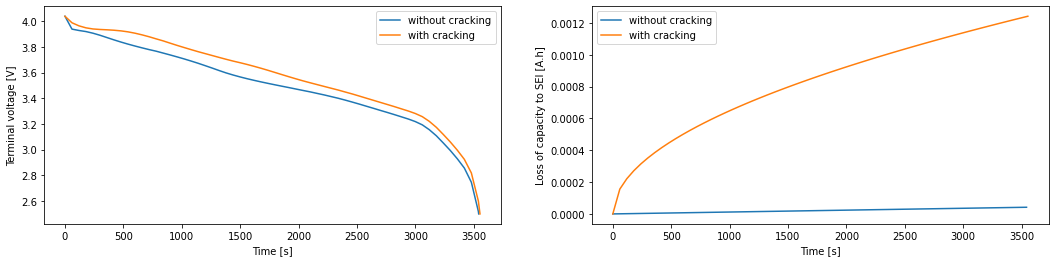

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4))
ax1.plot(t1,V1,label="without cracking")
ax1.plot(t2,V2,label="with cracking")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Terminal voltage [V]")
ax1.legend()
ax2.plot(t1,SEI1,label="without cracking")
ax2.plot(t2,SEI2,label="with cracking")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Loss of capacity to SEI [A.h]")
ax2.legend()
plt.show()

The SEI on cracks consumes far more capacity than the SEI on the initial surface, in agreement with the literature.

In [7]:
pybamm.print_citations()

[1] Weilong Ai, Ludwig Kraft, Johannes Sturm, Andreas Jossen, and Billy Wu. Electrochemical thermal-mechanical modelling of stress inhomogeneity in lithium-ion pouch cells. Journal of The Electrochemical Society, 167(1):013512, 2019. doi:10.1149/2.0122001JES.
[2] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[3] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical Society, 167(8):080534, 2020. doi:10.1149/1945-7111/ab9050.
[4] Rutooj Deshpande, Mark Verbrugge, Yang-Tse Cheng, John Wang, and Ping Liu. Battery cycle life prediction with coupled chemical degradation and fatigue mechanics. Journal of